In [1]:
!which python

/home/alin/.conda/envs/py37/bin/python


In [1]:
from pybbbc import BBBC021
import pandas as pd
import numpy as np
from pybbbc.utils import bytes_to_str
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from hydra.utils import instantiate
from omegaconf import DictConfig
from hydra.core.hydra_config import HydraConfig
from omegaconf import OmegaConf
from biomass.transforms import Standardize
from torch import nn
from biomass.poolers import MeanPooler
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from sklearn.neighbors import KNeighborsClassifier
from torchvision.transforms import Resize, Compose
from biomass.models import TorchVisionClassifier
from torch.nn import Identity
from biomass.models import ContrastiveLearner
import os
import scipy
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
torch.cuda.mem_get_info()

(11482365952, 11721506816)

In [3]:
!which python

/home/alin/.conda/envs/py37/bin/python


In [4]:
class BBBC021_Ljosa(BBBC021):
    """
    BBBC021 dataset as filtered by Ljosa et al., 2013.
    """
    def __init__(self, ljosa_path, root_path="~/.cache/", **kwargs):
        ljosa_df = pd.read_csv(
            ljosa_path, 
            delimiter='\t', 
            header=None, 
            usecols=[0, 1, 2, 10, 11, 35],
            names=["ljosa_table_id", "ljosa_image_id", "filename", "plate", "well", "replicate"]
        )
        ljosa_df['site'] = ljosa_df['filename'].apply(lambda x: int(x.split('_')[-2][-1]))
        super().__init__(root_path, **kwargs)
        image_df = pd.DataFrame({
            'plate': bytes_to_str(self.dataset["plate"][self.index_vector]),
            'well': bytes_to_str(self.dataset["well"][self.index_vector]),
            'site': self.dataset["site"][self.index_vector]
        })
        self.joint_df = pd.merge(image_df, ljosa_df, on=['plate', 'well', 'site'], how='left', indicator='exist')
        mask = self.joint_df['exist'] == 'both'
        self.index_vector = np.arange(len(self.joint_df))[mask]
        self.joint_df = self.joint_df[mask]

In [5]:
class BBBC021CellsDataset_Ljosa(Dataset):
    
    def __init__(self, ljosa_cell_path, ljosa_img_path, root_path, ximagesize, yimagesize, cropsize, 
                 xsize=1280, ysize=1024, min_area=250, transform=None, flip_order=[2, 1, 0]):
        self.img_dataset = BBBC021_Ljosa(ljosa_img_path, root_path)
        self.cell_df = pd.read_csv(ljosa_cell_path, delimiter='\t', header=None, usecols=[0, 1, 3, 4, 7],
                names=['table_id', 'image_id', 'nuclei_center_x', 
                       'nuclei_center_y', 'nuclei_area'])
        self.ximagesize = ximagesize
        self.yimagesize = yimagesize
        self.cropsize = cropsize
        self.xsize = xsize
        self.ysize = ysize
        self.xmid = self.xsize // 2
        self.ymid = self.ysize // 2
        self.xhalfimage = self.ximagesize // 2
        self.yhalfimage = self.yimagesize // 2
        self.halfcrop = self.cropsize // 2
        mask = (self.cell_df['nuclei_center_x'] >= self.xmid - self.xhalfimage + self.halfcrop) & \
                (self.cell_df['nuclei_center_y'] >= self.ymid - self.yhalfimage + self.halfcrop) & \
                (self.cell_df['nuclei_center_x'] <= self.xmid + self.xhalfimage - self.halfcrop) & \
                (self.cell_df['nuclei_center_y'] <= self.ymid + self.yhalfimage - self.halfcrop) & \
                (self.cell_df['nuclei_area'] >= min_area)
        self.cell_df = self.cell_df[mask]
        self.cell_df = self.cell_df.set_index(['table_id', 'image_id'])
        self.cell_df['nuclei_center_x'] = self.cell_df['nuclei_center_x'].round().astype(np.int64)
        self.cell_df['nuclei_center_y'] = self.cell_df['nuclei_center_y'].round().astype(np.int64)
        self.transform = transform
        self.flip_order = flip_order
    
    def __getitem__(self, idx):
        img, meta = self.img_dataset[idx]
        entry = self.img_dataset.joint_df.iloc[idx]
        try:
            table_id, img_id = entry['ljosa_table_id'], entry['ljosa_image_id']
            subset_df = self.cell_df.loc[table_id].loc[img_id]
            if isinstance(subset_df, pd.Series):
                subset_df = subset_df.to_frame()
            all_crops = [torch.tensor(img[:, y-self.halfcrop:y+self.halfcrop, x-self.halfcrop:x+self.halfcrop]) 
                         for x, y in subset_df[['nuclei_center_x', 'nuclei_center_y']].values]
            
            # Change from (Actin, Tubulin, DMSO) -> (DMSO, Tubulin, Actin)
            all_crops = [x[self.flip_order] for x in all_crops]
            if self.transform is not None:
                all_crops = [self.transform(x) for x in all_crops]
            return all_crops, meta
        except KeyError:
            return [], meta
    
    def __len__(self):
        return len(self.img_dataset)

In [6]:
class PlateSampler:
    def __init__(self, dataset, random: bool = True, use_batch: bool = False):
        self.image_df = dataset.img_dataset.image_df
        if use_batch:
            self.col = self.image_df['plate'].apply(lambda x: x.split('_')[0])
        else:
            self.col = self.image_df['plate']
        self.plates = self.col.unique()
        self.random = random

    def __iter__(self):
        indexes = np.arange(self.__len__())
        if self.random:
            np.random.shuffle(indexes)
        for plate_id in indexes:
            plate = self.plates[plate_id]
            all_imgs = self.image_df[self.col == plate].index
            yield np.array(all_imgs)

    def __len__(self):
        return len(self.plates)

In [7]:
def collate_fn(data):
    img_lists, metas = zip(*data)

    imgs = torch.stack([img for img_list in img_lists for img in img_list])
    lens = torch.tensor([len(img_list) for img_list in img_lists])

    return imgs, metas, lens

In [8]:
# sup_chkpt = torch.load("../blob/coos/checkpoints/erm_2022_06_23_00_19_27.pt")

# sup_model = TorchVisionClassifier(key="resnet50", classifier="fc", d_out=1139, pretrained=True)

# sup_model.load_state_dict(sup_chkpt)

# sup_model = sup_model.to('cuda')
# sup_model = sup_model.eval()

# sup_model.model.fc = Identity()

In [9]:
model_construct = """
model:
  _target_: biomass.models.ContrastiveLearner
  encoder:
    _target_: biomass.models.TorchVisionEncoder
    name: resnet50
    classifier_key: fc
    pretrained: False
  classifier:
    _target_: biomass.models.Linear
    in_features: 2048
    out_features: 1139
    bias: True
  proj_nonlinear: True
  proj_in: 2048
  proj_out: 128
"""

In [10]:
model = instantiate(OmegaConf.create(model_construct))["model"]
model.load_state_dict(torch.load("checkpoints/simclr_2022_08_30_03_25_00.pt"))
model = model.to('cuda')
model = model.eval()

/home/alin/.conda/envs/py37/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/alin/.conda/envs/py37/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# sup_model = TorchVisionClassifier(key="resnet50", classifier="fc", d_out=1139, pretrained=True)
# sup_model.load_state_dict(torch.load("checkpoints/simclr_2022_08_28_04_40_07.pt"))
# sup_model.model.fc = Identity()
# model = ContrastiveLearner(sup_model, classifier=None, proj_nonlinear=True, proj_in=2048, proj_out=128)
# model = model.to('cuda')
# model = model.train()

In [12]:
for m in model.modules():
    if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        m.track_running_stats = True
        m.momentum = 1.0
        print('Turned on track runinng stats for ', m)

Turned on track runinng stats for  BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
Turned on track runinng stats for  BatchNorm2d(64, eps=1e-05, momentum=1.0, a

In [13]:
# for m in model.modules():
#     for n, c in m.named_children():
#         if isinstance(c, torch.nn.modules.batchnorm._BatchNorm):
#             new_c = MyBatchNorm2d(c.num_features, c.eps, c.momentum,
#                  c.affine, c.track_running_stats)
#             new_c.load_state_dict(c.state_dict())
#             setattr(m, n, new_c)
#         print('Change BatchNorm2d to MyBatchNorm2d for ', n)

In [14]:
cell_data = BBBC021CellsDataset_Ljosa(
    '../bbbc_database/supplement_Object.txt', '../bbbc_database/supplement_Image.txt', "~/.cache/",
    ximagesize=1280, yimagesize=1024, cropsize=48, xsize=1280, ysize=1024, min_area=0, 
    transform=Compose([Standardize(dim=(-2, -1))]),
    flip_order=[2, 1, 0]
)

In [15]:
# class TestBatchSampler:
    
#     def __init__(self):
#         pass
    
#     def __iter__(self):
#         yield np.where(cell_data.img_dataset.image_df['moa'] == 'DMSO')[0]
    
#     def __len__():
#         return 1

# test_dl = DataLoader(cell_data, num_workers=12, pin_memory=True, collate_fn=collate_fn,
#                      batch_sampler=TestBatchSampler())
    
# batch = next(iter(test_dl))

# batch[0] = batch[0].to('cuda')

# with torch.no_grad():
#     out = model(batch[0])

In [16]:
# for m in model.modules():
#     if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
#         m.track_running_stats = False
#         print('Turned off track runinng stats for ', m)

In [17]:
sampler = PlateSampler(cell_data, random=False, use_batch=False)
dl = DataLoader(cell_data, num_workers=12, pin_memory=True, batch_sampler=sampler, collate_fn=collate_fn)

In [18]:
cell_data.img_dataset.joint_df['plate'].unique().shape

(55,)

In [19]:
@torch.no_grad()
def get_img_level_feats(img_dl, model):
    all_feats = [] 
    for batch in img_dl:
        imgs = batch[0].to('cuda')[:, [2, 1, 0], :, :]
        feats = model.encode(imgs)
        all_feats.append(feats.cpu())
    feats = torch.cat(all_feats)
    return feats

In [20]:
def whitening_transform(X, lambda_=1e-2, rotate=True):
    C = (1/X.shape[0]) * (X.T @ X)
    s, V = torch.linalg.eigh(C)
    d = 1. / torch.sqrt(s + lambda_)
    D = torch.diag(d)
    W = V @ D
    if rotate:
        W = W @ V.T
        
    return W

def whiten(X, mu, W):
    return (X - mu) @ W

In [21]:
@torch.no_grad()
def get_img_feats(
    model: nn.Module,
    pooler: nn.Module,
    loader: DataLoader,
    device: str,
    use_projs: bool,
    normalize: bool,
    adaptive: bool,
):
    all_feats = []
    for batch_id, (images, metas, lens) in enumerate(loader):
        
        images = images.to(device)
        lens = lens.to(device)
        
        if adaptive:
            # Use DMSO controls to compute batch statistics
            model = model.train()
            compounds = np.array([m.compound.compound for m in metas])
            mask = torch.tensor(compounds == 'DMSO', device=device)
            mask_images = torch.repeat_interleave(mask, lens)
            feats = torch.zeros((len(lens), 2048), device=device)
            feats[mask] = process_batch(model, images[mask_images], lens[mask], pooler, use_projs, normalize)

            # Use those statistics to evaluate on the full batch
            model = model.eval()
            if not mask.all():
                feats[~mask] = process_batch(model, images[~mask_images], lens[~mask], pooler, use_projs, normalize)
        else:
            feats = process_batch(model, images, lens, pooler, use_projs, normalize)
        assert len(feats) == len(metas)

        all_feats.append(feats.cpu())
        print('Finished', batch_id)
            
    feats = torch.cat(all_feats, dim=0)
    
    return feats

@torch.no_grad()
def process_batch(model, images: nn.Module, lens: torch.Tensor, pooler: nn.Module, use_projs: bool, normalize: bool):
    if use_projs:
        feats = model.project(images)
    else:
        feats = model.encode(images)

    if normalize:
        feats = F.normalize(feats, dim=1)

    feats_sets = torch.split(feats, lens.cpu().numpy().tolist())

    # Max pooling
    feats = torch.stack([pooler(feats_set) for feats_set in feats_sets], dim=0)
    
    return feats

In [22]:
feats = get_img_feats(model, MeanPooler(), dl, device='cuda', use_projs=False, normalize=True, 
                      adaptive=False)

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54


In [23]:
# img_dl = DataLoader(cell_data.img_dataset, batch_size=75, shuffle=False, drop_last=False)
# feats = get_img_level_feats(img_dl, model)

In [24]:
df = cell_data.img_dataset.image_df

In [25]:
mask = (~(torch.isnan(feats)).any(dim=1))

In [26]:
df = df[mask.numpy()]

In [27]:
feats = feats[mask]

In [28]:
feats

tensor([[0.0253, 0.0044, 0.0081,  ..., 0.0355, 0.0170, 0.0299],
        [0.0254, 0.0043, 0.0076,  ..., 0.0355, 0.0169, 0.0303],
        [0.0251, 0.0043, 0.0079,  ..., 0.0353, 0.0171, 0.0303],
        ...,
        [0.0249, 0.0042, 0.0076,  ..., 0.0358, 0.0166, 0.0301],
        [0.0250, 0.0044, 0.0075,  ..., 0.0356, 0.0169, 0.0300],
        [0.0250, 0.0043, 0.0078,  ..., 0.0355, 0.0172, 0.0302]])

In [29]:
# feats = torch.tensor(PCA(n_components=1000).fit_transform(feats.numpy()))

In [30]:
df[list(range(feats.shape[1]))] = feats.numpy()

/home/alin/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/home/alin/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


/home/alin/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


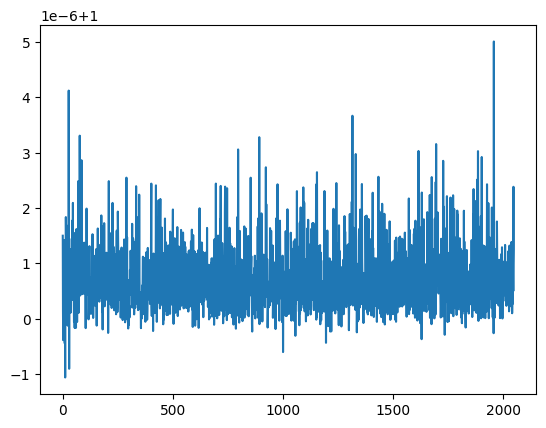

In [69]:
use_whitening = True
lambda_ = 0.02
if use_whitening:
    controls_mask = torch.tensor((df['compound'] == 'DMSO').values)
    controls = feats[controls_mask]
    control_means = controls.mean(dim=0)
    controls = controls - control_means
    W = whitening_transform(controls, lambda_=lambda_)
    whitened_feats = whiten(feats, control_means, W)
    
    df[list(range(feats.shape[1]))] = whitened_feats.numpy()
    
    whitened_controls = whitened_feats[controls_mask]
    C_target = 1 / whitened_controls.shape[0] * whitened_controls.T @ whitened_controls
    C_target = C_target + torch.eye(len(C_target))
    C_target = np.real(scipy.linalg.sqrtm(C_target.cpu().numpy()))
    plt.plot(np.diag(C_target))

In [82]:
use_tvn = True
if use_tvn:
    tvn_feats = df[list(range(feats.shape[1]))].copy()
    batches = df['plate']
#     batches = df['plate'].apply(lambda x: x.split('_')[0])
    for b in batches.unique():
        plate_df = df[batches == b]
        controls_features = plate_df[list(range(feats.shape[1]))][plate_df['compound'] == 'DMSO'].values
        all_features = plate_df[list(range(feats.shape[1]))].values
        
        C_source = (1/controls_features.shape[0]) * (controls_features.T @ controls_features)
        C_source = scipy.linalg.inv(np.real(scipy.linalg.sqrtm(C_source + np.eye(len(C_source)))))
        
        new_features = (all_features @ C_source) @ C_target        
        tvn_feats.loc[plate_df.index] = new_features
        print(f'Finished {b}')
    
    df[list(range(feats.shape[1]))] = tvn_feats.values

Finished Week1_22361
Finished Week3_25721
Finished Week7_34661
Finished Week3_25681
Finished Week7_34341
Finished Week4_27861
Finished Week1_22401
Finished Week4_27521
Finished Week4_27821
Finished Week5_28921
Finished Week3_25701
Finished Week5_29321
Finished Week10_40111
Finished Week9_39221
Finished Week9_39206
Finished Week4_27542
Finished Week6_32161
Finished Week1_22161
Finished Week6_32061
Finished Week3_25461
Finished Week1_22381
Finished Week10_40115
Finished Week1_22141
Finished Week3_25441
Finished Week4_27481
Finished Week9_39301
Finished Week2_24381
Finished Week3_25421
Finished Week9_39282
Finished Week2_24121
Finished Week5_28901
Finished Week6_31661
Finished Week7_34641
Finished Week9_39283
Finished Week5_29301
Finished Week2_24361
Finished Week4_27801
Finished Week2_24141
Finished Week5_28961
Finished Week8_38203
Finished Week6_31641
Finished Week10_40119
Finished Week1_22123
Finished Week7_34381
Finished Week7_34681
Finished Week6_32121
Finished Week5_29341
Finished W

/home/alin/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [83]:
well_df = df.groupby(['moa', 'compound', 'concentration', 'plate', 'well'], observed=True).mean() 
well_df['batch'] = [x.split('_')[0] for x in well_df.index.get_level_values(3)]
compound_df = well_df.groupby(level=[0, 1, 2], observed=True).median()
compound_df['batch'] = well_df['batch'].groupby(level=[0, 1, 2]).apply(lambda x: ",".join(x.unique()))

In [84]:
compound_df['batch'].unique()

array(['Week1', 'Week2', 'Week3', 'Week7',
       'Week1,Week3,Week7,Week4,Week5,Week10,Week9,Week6,Week2,Week8',
       'Week4', 'Week6', 'Week5', 'Week10', 'Week8', 'Week9'],
      dtype=object)

In [85]:
compound_df = compound_df.drop(index='DMSO')

In [86]:
compound_feats = compound_df[range(feats.shape[1])].values
# compound_feats = compound_feats / np.linalg.norm(compound_feats, axis=1).reshape(-1, 1)

In [87]:
transformed = TSNE(n_components=2).fit_transform(compound_feats)

/home/alin/.conda/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/alin/.conda/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [88]:
colors = list(mcolors.TABLEAU_COLORS.keys()) + ['lime', 'yellow', 'magenta']

In [89]:
moas = compound_df.index.get_level_values(0)
unique_moas = moas.unique()

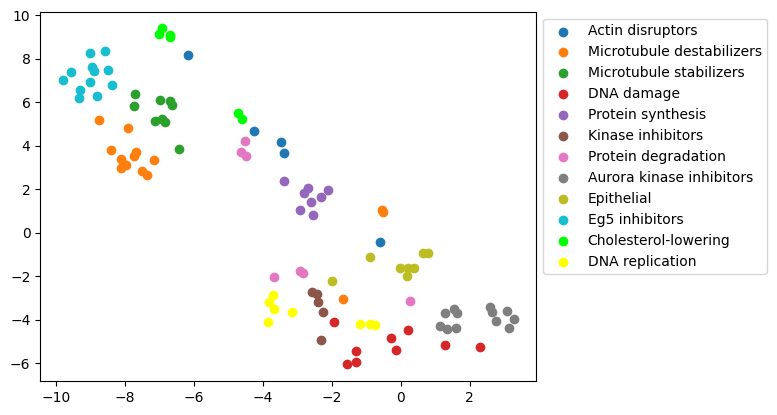

In [90]:
for idx, moa in enumerate(unique_moas):
    mask = (moas == moa)
    plt.scatter(transformed[:, 0][mask], transformed[:, 1][mask], c=colors[idx])
plt.legend(unique_moas, bbox_to_anchor=(1, 1))

In [91]:
def knn(X, Y, T):
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm="brute", metric="cosine")
    neigh.fit(X, Y)
    prediction = neigh.predict(T.reshape(1, -1))
    return prediction[0]

def nsc(compound_feats, compounds, moas): 
    corrects = []
    for i in range(len(compound_feats)):
        mask = (compounds != compounds[i])
        pred = knn(compound_feats[mask], moas[mask], compound_feats[i])
        if pred == moas[i]:
            corrects.append(True)
        else:
            corrects.append(False)
    return corrects

In [92]:
corrects = nsc(compound_feats, compounds=compound_df.index.get_level_values(1), moas=compound_df.index.get_level_values(0))
np.mean(corrects)

0.7572815533980582

In [93]:
def nscb(compound_feats, compounds, moas, batches):
    corrects = []
    for i in range(len(compound_feats)):
        if moas[i] in ["Cholesterol-lowering", "Kinase inhibitors"]:
            corrects.append(np.nan)
        else:
            mask = (compounds != compounds[i]) & (batches != batches[i])
            pred = knn(compound_feats[mask], moas[mask], compound_feats[i])
            if pred == moas[i]:
                corrects.append(True)
            else:
                corrects.append(False)
    return corrects

In [94]:
corrects2 = nscb(compound_feats, compounds=compound_df.index.get_level_values(1), 
                 moas=compound_df.index.get_level_values(0), batches=compound_df['batch'].values)
np.nanmean(corrects2)

0.5978260869565217

In [95]:
compound_df['corrects'] = corrects

<AxesSubplot:xlabel='moa', ylabel='accuracy'>

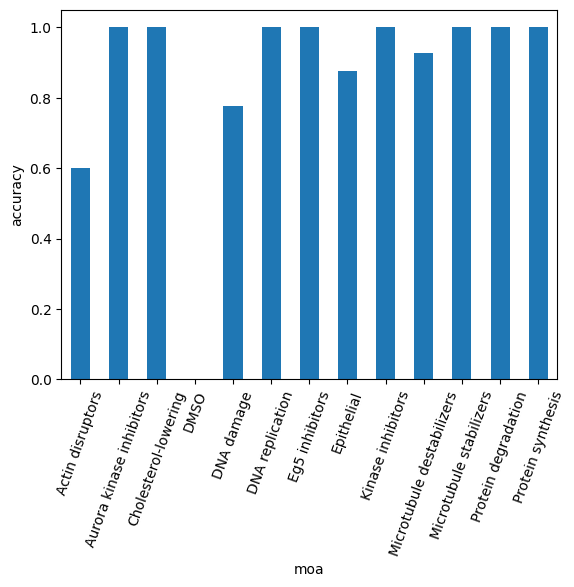

In [137]:
compound_df['corrects'].groupby(level=0).mean().plot.bar(ylabel='accuracy', rot=70)